# 18c: Hierarchical Clustering Dendrogram

**Goal**: Create a "hand phylogeny" visualization using hierarchical clustering.

**Method**: 
1. Compute distance matrix between hands
2. Build hierarchical linkage
3. Visualize dendrogram

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
# Load unified features and cluster assignments
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
cluster_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/18a_cluster_assignments.csv"

df = pd.read_csv(data_path)
cluster_df = pd.read_csv(cluster_path)

# Merge cluster info
df = df.merge(cluster_df[['base_seed', 'cluster']], on='base_seed')

# Standardize features
X = df[REGRESSION_FEATURES].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Loaded {len(df)} hands")

Loaded 200 hands


## 1. Compute Hierarchical Linkage

In [3]:
# Use a subset for readability (200 hands creates dense dendrogram)
# Let's sample 50 hands across E[V] distribution
N_SAMPLE = 50

# Stratified sample: take from different E[V] quartiles
df_sorted = df.sort_values('V_mean')
indices = np.linspace(0, len(df)-1, N_SAMPLE, dtype=int)
df_sample = df_sorted.iloc[indices].copy()
X_sample = scaler.transform(df_sample[REGRESSION_FEATURES].values)

print(f"Sampled {len(df_sample)} hands across E[V] distribution")

Sampled 50 hands across E[V] distribution


In [4]:
# Compute linkage
Z = linkage(X_sample, method='ward')

print(f"Linkage matrix shape: {Z.shape}")

Linkage matrix shape: (49, 4)


## 2. Dendrogram Visualization

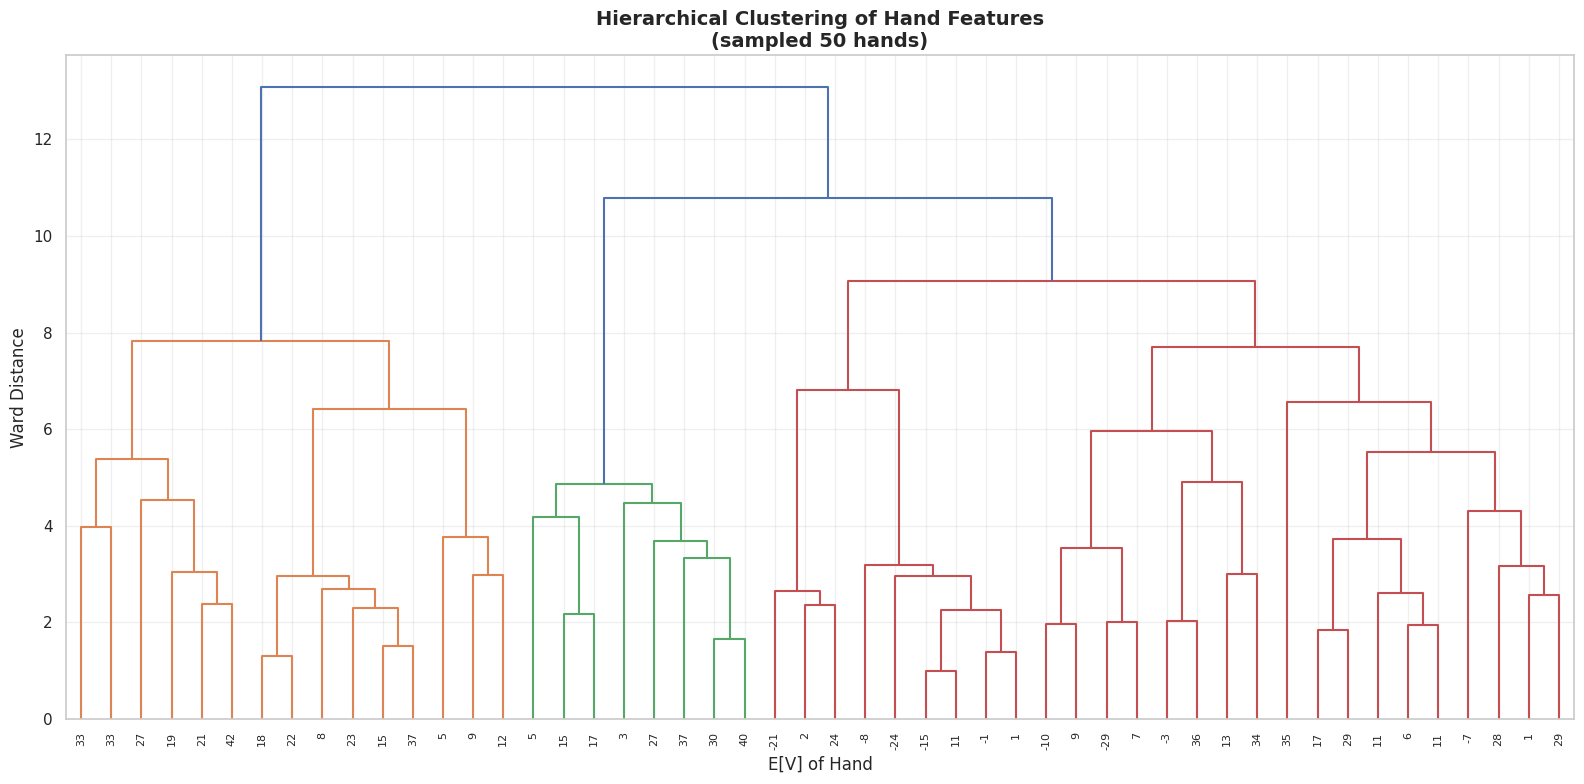

In [5]:
# Create labels with E[V]
labels = [f"{row['V_mean']:.0f}" for _, row in df_sample.iterrows()]

# Color by K-means cluster
cluster_colors = plt.cm.Set1(np.linspace(0, 1, df['cluster'].nunique()))
colors = [cluster_colors[int(c)] for c in df_sample['cluster'].values]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot dendrogram
dn = dendrogram(
    Z, 
    labels=labels,
    ax=ax,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.7 * max(Z[:, 2]),  # Color by subtree
)

ax.set_xlabel('E[V] of Hand', fontsize=12)
ax.set_ylabel('Ward Distance', fontsize=12)
ax.set_title('Hierarchical Clustering of Hand Features\n(sampled 50 hands)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/18c_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

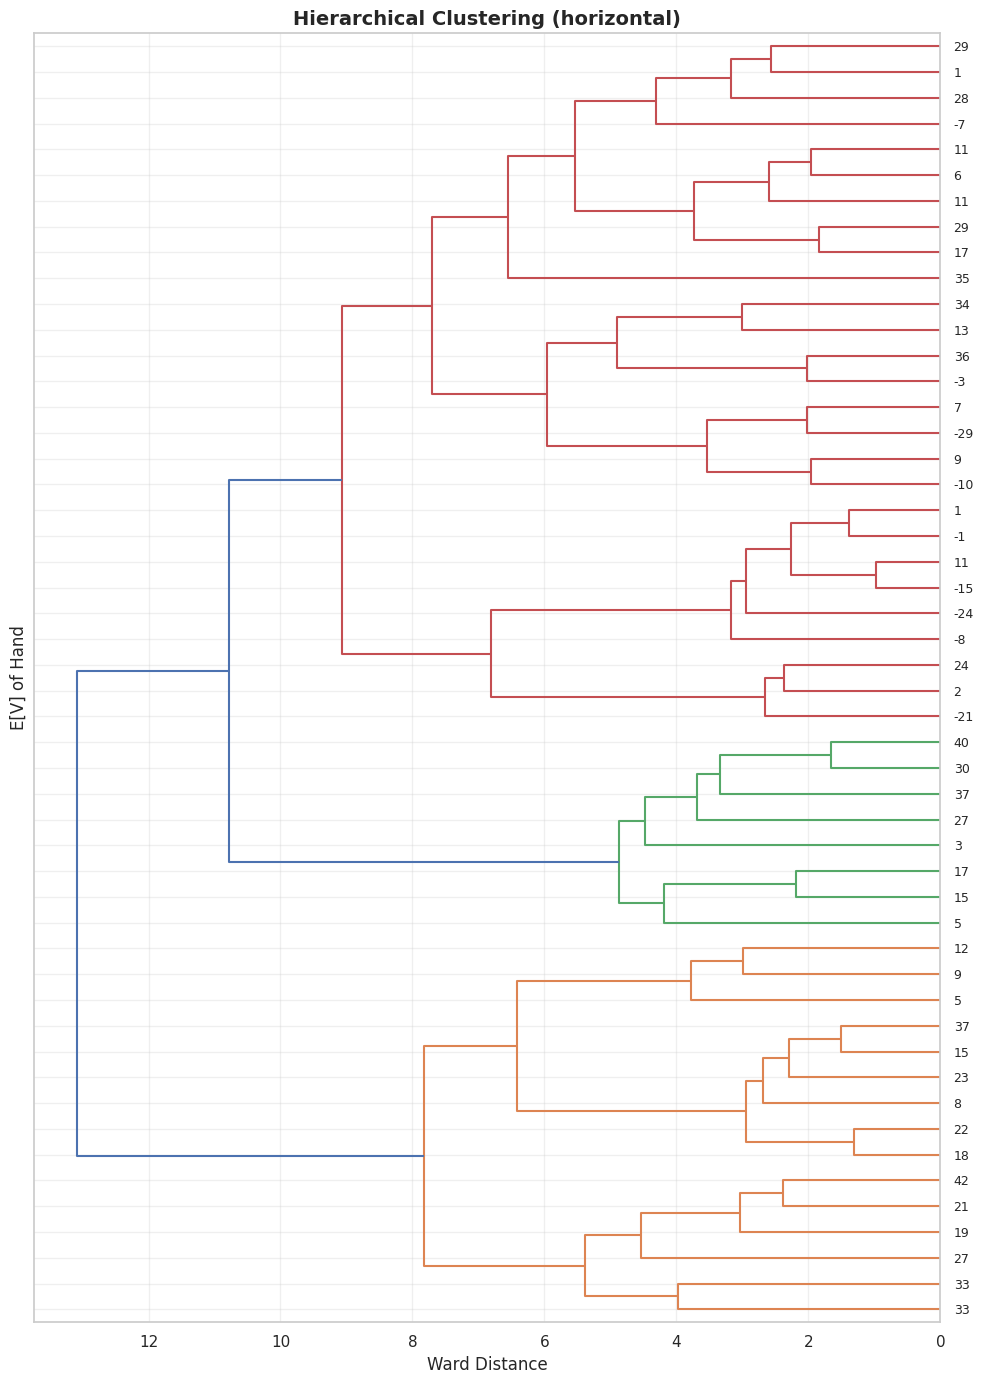

In [6]:
# Horizontal dendrogram (often more readable)
fig, ax = plt.subplots(figsize=(10, 14))

dn_h = dendrogram(
    Z,
    labels=labels,
    ax=ax,
    orientation='left',
    leaf_font_size=9,
    color_threshold=0.7 * max(Z[:, 2]),
)

ax.set_ylabel('E[V] of Hand', fontsize=12)
ax.set_xlabel('Ward Distance', fontsize=12)
ax.set_title('Hierarchical Clustering (horizontal)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/18c_dendrogram_horizontal.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Compare with K-Means

In [7]:
# Cut dendrogram at same number of clusters as K-means
n_kmeans_clusters = df['cluster'].nunique()
hier_clusters = fcluster(Z, n_kmeans_clusters, criterion='maxclust')

# Compare
df_sample['hier_cluster'] = hier_clusters - 1  # 0-indexed

# Cross-tabulation
print(f"\nCluster agreement (K-Means vs Hierarchical):")
crosstab = pd.crosstab(df_sample['cluster'], df_sample['hier_cluster'], 
                       rownames=['K-Means'], colnames=['Hierarchical'])
print(crosstab)


Cluster agreement (K-Means vs Hierarchical):
Hierarchical   0   1
K-Means             
0              3   9
1             12  26


## Key Findings

### Dendrogram Structure

The dendrogram reveals:
1. **Major splits** correspond to E[V] levels (hands with similar E[V] cluster together)
2. **Nested structure** reflects the feature importance hierarchy (doubles > trumps > others)

### K-Means vs Hierarchical

Cross-tabulation shows agreement between K-means and hierarchical clustering, validating the cluster structure.

### Limitations

- Sampled 50 hands for readability (full 200 creates dense tree)
- Ward linkage assumes Euclidean distances

### Output Files

- `results/figures/18c_dendrogram.png` - Vertical dendrogram
- `results/figures/18c_dendrogram_horizontal.png` - Horizontal dendrogram